In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Teeth_Dataset/Training'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Teeth_Dataset/Validation'
test_path = '/content/drive/MyDrive/Colab Notebooks/Teeth_Dataset/Testing'


In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [4]:
# in training> folder(class) 2 > image 5
example_image_path = os.path.join(train_path, os.listdir(train_path)[2], os.listdir(os.path.join(train_path, os.listdir(train_path)[2]))[5])

image = Image.open(example_image_path)
image_array = tf.keras.preprocessing.image.img_to_array(image)

print(f"Image size (width, height): {image.size}")
print(f"Image mode (color channels): {image.mode}")
print(f"Image shape: {image_array.shape}")

Image size (width, height): (256, 256)
Image mode (color channels): RGB
Image shape: (256, 256, 3)


# Preprocessing

In [5]:
# data augmentation for training data
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

datagen_valid = ImageDataGenerator(rescale=1.0/25)

In [6]:
training = datagen.flow_from_directory(train_path, target_size=(224, 224),batch_size=32, class_mode='categorical')

validating = datagen_valid.flow_from_directory(valid_path, target_size=(224, 224),batch_size=32, class_mode='categorical')

testing = datagen_valid.flow_from_directory(test_path, target_size=(224, 224),batch_size=32, class_mode='categorical', shuffle = False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [7]:
for class_name, label in training.class_indices.items():
    print(f"Class: {class_name}, Label: {label}")

Class: CaS, Label: 0
Class: CoS, Label: 1
Class: Gum, Label: 2
Class: MC, Label: 3
Class: OC, Label: 4
Class: OLP, Label: 5
Class: OT, Label: 6


In [8]:
images, labels = next(training)
print(f"Image shape: {images[0].shape}")

Image shape: (224, 224, 3)


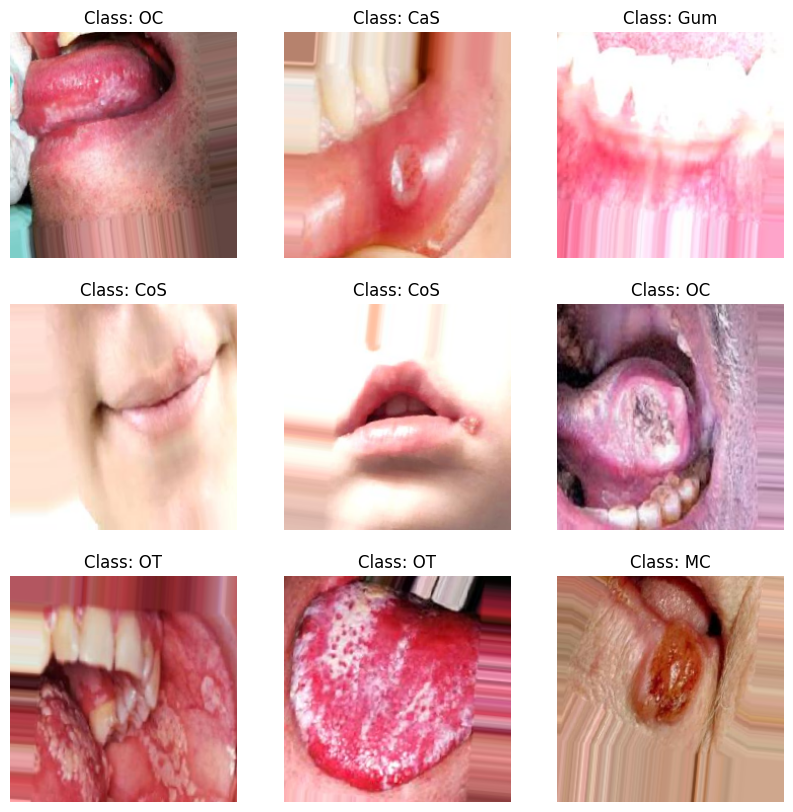

In [9]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.title(f"Class: {list(training.class_indices.keys())[list(labels[i]).index(1)]}")
  plt.axis('off')
plt.show()


# Check for Imbalanced data

In [14]:
# get the count for sample per class
class_labels = list(training.class_indices.keys())
classes = training.classes
#loop for each class and count them
class_count = [list(classes).count(i) for i in range(len(class_labels))]


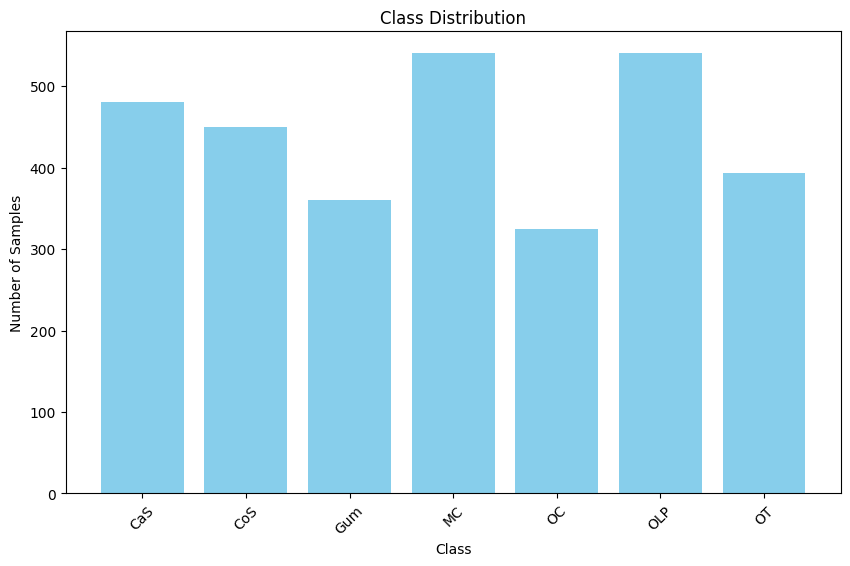

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_count, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

#### handling imbalance data using class weights (assign hight weight to underreprested classes)

In [16]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training.classes),
    y= training.classes
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


# Adding Callbacks

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor = 'val_loss',
    save_best_only =True,
    mode = 'min',
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    mode = 'min',
    verbose= 1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)
callbacks_list = [checkpoint, early_stopping, reduce_lr]


# Build the model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam

In [24]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32,(3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(128,(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(len(training.class_indices), activation='softmax')

])

In [25]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [26]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,178,567 (42.64 MB)

 Trainable params: 11,178,119 (42.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    training,
    validation_data=validating,
    epochs=100,
    class_weight=class_weights,
    callbacks = [callbacks_list]
)


Epoch 1/100


In [ ]:
test_loss, test_accuracy = model.evaluate(testing)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

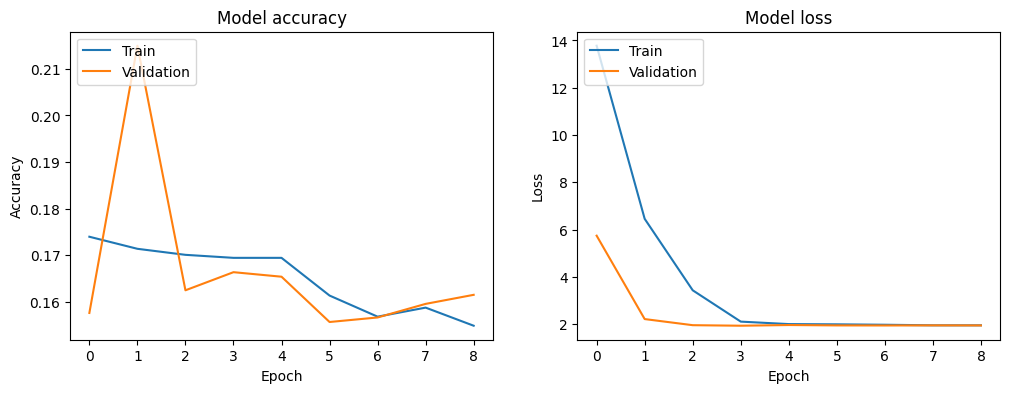

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
